In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv
/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv
/kaggle/input/equity-post-HCT-survival-predictions/train.csv
/kaggle/input/equity-post-HCT-survival-predictions/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
 
import torch
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder, FunctionTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, roc_curve, auc, mean_squared_error, r2_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU: Tesla T4


In [4]:
df_train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv', index_col='ID')
df_test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv', index_col='ID')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28800 entries, 0 to 28799
Data columns (total 59 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dri_score               28646 non-null  object 
 1   psych_disturb           26738 non-null  object 
 2   cyto_score              20732 non-null  object 
 3   diabetes                26681 non-null  object 
 4   hla_match_c_high        24180 non-null  float64
 5   hla_high_res_8          22971 non-null  float64
 6   tbi_status              28800 non-null  object 
 7   arrhythmia              26598 non-null  object 
 8   hla_low_res_6           25530 non-null  float64
 9   graft_type              28800 non-null  object 
 10  vent_hist               28541 non-null  object 
 11  renal_issue             26885 non-null  object 
 12  pulm_severe             26665 non-null  object 
 13  prim_disease_hct        28800 non-null  object 
 14  hla_high_res_6          23516 non-null  flo

In [6]:
X = df_train.iloc[:, :-2]

In [7]:
y=df_train['efs']

In [8]:
numerical_columns = X.select_dtypes(include=['number']).columns
categorical_columns = X.select_dtypes(include=['object']).columns

In [9]:
drop_columns = ['tce_imm_match', 'cyto_score_detail', 'mrd_hct', 'tce_match', 'tce_div_match' ]

In [10]:
ordinal_categorical_columns = ['cyto_score',]

remaining_cat_columns = [col for col in categorical_columns if col not in drop_columns and col not in ordinal_categorical_columns]

In [11]:
# Custom transformer class to drop columns
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        # No fitting necessary for dropping columns
        return self

    def transform(self, X):
        # Drop specified columns
        return X.drop(columns=self.columns_to_drop, errors='ignore')

    def get_feature_names_out(self, input_features=None):
        # Get feature names after dropping columns
        if input_features is None:
            input_features = []
        remaining_columns = [col for col in input_features if col not in self.columns_to_drop]
        return remaining_columns
 

In [12]:
class HandleOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, p_min=0.01, p_max=0.99):
        self.p_min = p_min
        self.p_max = p_max

    def fit(self, X, y=None):
        # Fit method is required by the estimator interface but we don't need to do anything here
        return self

    def transform(self, X):
        X = pd.DataFrame(X)  # Ensure it's a DataFrame for easy processing
        for column in X.columns:
            # Calculate the min and max percentiles
            p_min_value = X[column].quantile(self.p_min)
            p_max_value = X[column].quantile(self.p_max)

            # Replace values below min percentile and above max percentile
            X[column] = X[column].clip(lower=p_min_value, upper=p_max_value)

            # Replace missing values with the median
            median = X[column].median()
            X[column] = X[column].fillna(median)

        return X.values  # Return as numpy array for compatibility with sklearn

    def get_feature_names_out(self, input_features=None):
        # Return the same feature names as input
        return input_features

In [13]:
class NumericalImputer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to impute numerical columns with specified strategies.
    """
    def __init__(self, impute_dict=None):
        """
        Initialize the transformer with a dictionary of imputation strategies.

        Args:
        - impute_dict (dict): Dictionary mapping column names to imputation strategies.
          e.g., {'Age': 'median', 'Number of Dependents': 0}
        """
        self.impute_dict = impute_dict

    def fit(self, X, y=None):
        """
        Fit the transformer by calculating the required statistics for each column.

        Args:
        - X (pd.DataFrame): Input data.
        - y: Ignored.
        
        Returns:
        - self: Fitted transformer.
        """
        self.statistics_ = {}
        for col, strategy in self.impute_dict.items():
            if strategy == "median":
                self.statistics_[col] = X[col].median()
            elif strategy == "mean":
                self.statistics_[col] = X[col].mean()
            elif strategy == 0:  # Use 0 for imputation
                self.statistics_[col] = 0
            else:
                raise ValueError(f"Unsupported strategy: {strategy}")
        return self

    def transform(self, X):
        """
        Transform the data by imputing the specified columns.

        Args:
        - X (pd.DataFrame): Input data.

        Returns:
        - pd.DataFrame: Transformed data with imputed values.
        """
        X = X.copy()
        for col, value in self.statistics_.items():
            X[col] = X[col].fillna(value)
        return X

    def get_feature_names_out(self, input_features=None):
        """
        Get output feature names for compatibility with ColumnTransformer.

        Args:
        - input_features (array-like or None): Input feature names. Ignored.

        Returns:
        - list: Feature names (column names) after transformation.
        """
        return list(self.impute_dict.keys())

In [14]:
class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    """
    A custom transformer to apply LabelEncoder to specified columns.
    """
    def __init__(self, columns=None):
        """
        Initialize the transformer.

        Args:
        - columns (list): List of column names to encode.
        """
        self.columns = columns
        self.encoders = {}

    def fit(self, X, y=None):
        """
        Fit LabelEncoder for each specified column.

        Args:
        - X (pd.DataFrame): Input data.
        - y: Ignored.

        Returns:
        - self: Fitted transformer.
        """
        if self.columns is None:
            self.columns = X.columns.tolist()

        for col in self.columns:
            encoder = LabelEncoder()
            X[col] = X[col].astype(str)  # Ensure all data is string
            encoder.fit(X[col])
            self.encoders[col] = encoder

        return self

    def transform(self, X):
        """
        Transform the data by encoding the specified columns.

        Args:
        - X (pd.DataFrame): Input data.

        Returns:
        - pd.DataFrame: Transformed data with encoded values.
        """
        X = X.copy()

        for col in self.columns:
            X[col] = X[col].astype(str)  # Ensure all data is string
            X[col] = self.encoders[col].transform(X[col])

        return X

    def inverse_transform(self, X):
        """
        Inverse transform the data to decode encoded values back to original categories.

        Args:
        - X (pd.DataFrame): Input data with encoded values.

        Returns:
        - pd.DataFrame: Decoded data with original categories.
        """
        X = X.copy()

        for col in self.columns:
            X[col] = self.encoders[col].inverse_transform(X[col].astype(int))

        return X

    def get_feature_names_out(self, input_features=None):
        """
        Get output feature names for compatibility.

        Args:
        - input_features (array-like or None): Input feature names.

        Returns:
        - list: Feature names after transformation.
        """
        return self.columns

In [15]:
class AgeToRangeTransformer(BaseEstimator, TransformerMixin):
    """
    A transformer that converts one or more age columns into categorical age ranges.
    
    Parameters:
    columns (list of str): The names of the columns containing age values to transform.
    """
    
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        """
        Fit the transformer to the data (no fitting needed for this transformation).
        
        Parameters:
        X (pd.DataFrame): The input data.
        y (optional): The target variable (not used).
        
        Returns:
        self: The fitted transformer.
        """
        return self

    def transform(self, X):
        """
        Transform the input data by converting age columns into categorical age ranges.
        
        Parameters:
        X (pd.DataFrame): The input data containing the age columns.
        
        Returns:
        pd.DataFrame: The transformed data with the age ranges as new columns.
        """
        X = X.copy()  # Avoid modifying the original dataframe

        for column in self.columns:
            # Ensure the provided column exists in the data
            if column not in X.columns:
                raise ValueError(f"Column '{column}' not found in the input data.")

            # Handle missing values (adjust as needed)
            X[column].fillna(X[column].median(), inplace=True)
            
            # Create the 'age_range' column based on the age column
            age_range = pd.cut(X[column], bins=[0, 20, 30, 40, 50, 60, 70, float('inf')],
                               labels=['Below 20', '20-30', '30-40', '40-50', '50-60', '60-70', '70+'])
            
            X[f'{column}_range'] = age_range  # Add the new 'age_range' column
            X = X.drop(columns=[column])  # Drop the original age column
        
        return X

    def get_feature_names_out(self, input_features=None):
        """
        Return the feature names after transformation.
        
        Parameters:
        input_features (optional): The original feature names (not used).
        
        Returns:
        list: A list containing the transformed feature names.
        """
        return [f'{col}_range' for col in self.columns]

In [16]:
# Define the categorical imputation pipeline
categorical_impute_pipeline = Pipeline(steps=[
    ('lab_encode', LabelEncoderTransformer()),  # Encode categorical data
    ('knn_impute', KNNImputer(n_neighbors=5))  # Apply KNN Imputation
])

ordinal_impute_pipeline = Pipeline(steps=[
    ('ord_encode', OrdinalEncoder(categories=[['Not Tested','TBD','Other','Poor','Favorable', 'Intermediate', 'Normal']],
                                  handle_unknown='use_encoded_value', unknown_value=-1)),  # Handle NaN
    ('knn_impute_ord', KNNImputer(n_neighbors=5))  # Apply KNN Imputation
])


In [17]:
df_train['cyto_score'].value_counts()

cyto_score
Poor            8802
Intermediate    6376
Favorable       3011
TBD             1341
Normal           643
Other            504
Not tested        55
Name: count, dtype: int64

In [18]:

age_columns = ['donor_age', 'age_at_hct']

outlier_handling_columns = [ 'comorbidity_score', 'karnofsky_score' ]

remaining_numerical_columns = [col for col in numerical_columns if col not in outlier_handling_columns and col not in age_columns]


# Create a pipeline for age transformation followed by one-hot encoding
age_pipeline = Pipeline(steps=[
    ('age_transformer',  AgeToRangeTransformer(columns = age_columns)),  # Apply age transformation
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))  # OneHotEncode the age_range column
])

# Define the numerical pipeline
outlier_pipeline = Pipeline(steps=[
    ('outlier_handling', HandleOutliers(p_min=0.0025, p_max=0.9975)),  # Apply outlier handling
    ('scaling', StandardScaler())  # Apply standard scaling
])

# Define the numerical pipeline
numerical_pipeline = Pipeline(steps=[
    ('num_processing', SimpleImputer(strategy='median')),  # Apply numerical imputation and outlier handling
    ('scaling', StandardScaler())  # Apply standard scaling
])





In [19]:

# ColumnTransformer with preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('drop', DropColumnsTransformer(drop_columns), drop_columns),  # OneHotEncode other categorical columns
        ('age_transformation',age_pipeline,  age_columns),
        ("cat_impute_transformation", categorical_impute_pipeline, remaining_cat_columns),  # Impute categorical columns 
        ("cyto_score_transformation",  ordinal_impute_pipeline,ordinal_categorical_columns),
        ("outlier_transformation", outlier_pipeline,outlier_handling_columns ),
        ("num_transformation", numerical_pipeline, remaining_numerical_columns),  # Apply numerical transformations
    ],
    remainder='passthrough'  # Pass through any columns not explicitly transformed
)
 
# Create a pipeline with PCA or any other estimator after preprocessing
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)  # Apply preprocessing for both categorical and numerical columns
])


In [20]:
pipeline.fit(X)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop',
                                                  DropColumnsTransformer(columns_to_drop=['tce_imm_match',
                                                                                          'cyto_score_detail',
                                                                                          'mrd_hct',
                                                                                          'tce_match',
                                                                                          'tce_div_match']),
                                                  ['tce_imm_match',
                                                   'cyto_score_detail',
                                                   'mrd_hct', 'tce_match',
                                                   'tce_div_match']),
                                                 ('age_transformation',
                                                  Pipeline(steps=[('age_transformer',
                                                                   AgeT...
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['hla_match_c_high',
                                                   'hla_high_res_8',
                                                   'hla_low_res_6',
                                                   'hla_high_res_6',
                                                   'hla_high_res_10',
                                                   'hla_match_dqb1_high',
                                                   'hla_nmdp_6',
                                                   'hla_match_c_low',
                                                   'hla_match_drb1_low',
                                                   'hla_match_dqb1_low',
                                                   'year_hct',
                                                   'hla_match_a_high',
                                                   'hla_match_b_low',
                                                   'hla_match_a_low',
                                                   'hla_match_b_high',
                                                   'hla_low_res_8',
                                                   'hla_match_drb1_high',
                                                   'hla_low_res_10'])]))])

In [21]:
transformed_X = pipeline.transform(X)

In [22]:
transformed_X

array([[ 0.        ,  1.        ,  0.        , ...,  0.63525451,
         0.58342624,  0.61716842],
       [ 0.        ,  0.        ,  0.        , ...,  0.63525451,
         0.58342624,  0.61716842],
       [ 0.        ,  1.        ,  0.        , ...,  0.63525451,
         0.58342624,  0.61716842],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.63525451,
         0.58342624,  0.61716842],
       [ 0.        ,  0.        ,  1.        , ..., -2.01864649,
        -1.67105863, -2.18681494],
       [ 1.        ,  0.        ,  0.        , ...,  0.63525451,
         0.58342624,  0.61716842]])

In [23]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('drop',
                                 DropColumnsTransformer(columns_to_drop=['tce_imm_match',
                                                                         'cyto_score_detail',
                                                                         'mrd_hct',
                                                                         'tce_match',
                                                                         'tce_div_match']),
                                 ['tce_imm_match', 'cyto_score_detail',
                                  'mrd_hct', 'tce_match', 'tce_div_match']),
                                ('age_transformation',
                                 Pipeline(steps=[('age_transformer',
                                                  AgeToRangeTransformer(columns=['dono...
                                                 ('scaling',
                                                  StandardScaler())]),
                                 ['hla_match_c_high', 'hla_high_res_8',
                                  'hla_low_res_6', 'hla_high_res_6',
                                  'hla_high_res_10', 'hla_match_dqb1_high',
                                  'hla_nmdp_6', 'hla_match_c_low',
                                  'hla_match_drb1_low', 'hla_match_dqb1_low',
                                  'year_hct', 'hla_match_a_high',
                                  'hla_match_b_low', 'hla_match_a_low',
                                  'hla_match_b_high', 'hla_low_res_8',
                                  'hla_match_drb1_high', 'hla_low_res_10'])])

In [24]:
 # Get the feature names after transformation
transformed_feature_names = preprocessor.get_feature_names_out()
transformed_feature_names

array(['age_transformation__donor_age_range_30-40',
       'age_transformation__donor_age_range_40-50',
       'age_transformation__donor_age_range_50-60',
       'age_transformation__donor_age_range_60-70',
       'age_transformation__donor_age_range_70+',
       'age_transformation__donor_age_range_Below 20',
       'age_transformation__age_at_hct_range_30-40',
       'age_transformation__age_at_hct_range_40-50',
       'age_transformation__age_at_hct_range_50-60',
       'age_transformation__age_at_hct_range_60-70',
       'age_transformation__age_at_hct_range_70+',
       'age_transformation__age_at_hct_range_Below 20',
       'cat_impute_transformation__dri_score',
       'cat_impute_transformation__psych_disturb',
       'cat_impute_transformation__diabetes',
       'cat_impute_transformation__tbi_status',
       'cat_impute_transformation__arrhythmia',
       'cat_impute_transformation__graft_type',
       'cat_impute_transformation__vent_hist',
       'cat_impute_transformation

In [25]:
df_transformed_X =  pd.DataFrame(transformed_X, columns=transformed_feature_names)


In [26]:
df_transformed_X.head()

,age_transformation__donor_age_range_30-40,age_transformation__donor_age_range_40-50,age_transformation__donor_age_range_50-60,age_transformation__donor_age_range_60-70,age_transformation__donor_age_range_70+,age_transformation__donor_age_range_Below 20,age_transformation__age_at_hct_range_30-40,age_transformation__age_at_hct_range_40-50,age_transformation__age_at_hct_range_50-60,age_transformation__age_at_hct_range_60-70,...,num_transformation__hla_match_drb1_low,num_transformation__hla_match_dqb1_low,num_transformation__year_hct,num_transformation__hla_match_a_high,num_transformation__hla_match_b_low,num_transformation__hla_match_a_low,num_transformation__hla_match_b_high,num_transformation__hla_low_res_8,num_transformation__hla_match_drb1_high,num_transformation__hla_low_res_10
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.590556,0.479824,0.260175,0.57383,0.578537,0.598004,0.581206,0.635255,0.583426,0.617168
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.590556,0.479824,-2.276400,0.57383,0.578537,0.598004,0.581206,0.635255,0.583426,0.617168
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.590556,0.479824,1.211391,0.57383,0.578537,0.598004,0.581206,0.635255,0.583426,0.617168
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.590556,0.479824,-1.959328,0.57383,0.578537,0.598004,0.581206,0.635255,0.583426,0.617168
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.590556,0.479824,0.894319,0.57383,0.578537,0.598004,0.581206,0.635255,0.583426,0.617168


In [27]:
test_transformed = pipeline.transform(df_test)

In [28]:
df_test_transformed=  pd.DataFrame(test_transformed, columns=transformed_feature_names)


In [29]:
df_test_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 62 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   age_transformation__donor_age_range_30-40          3 non-null      float64
 1   age_transformation__donor_age_range_40-50          3 non-null      float64
 2   age_transformation__donor_age_range_50-60          3 non-null      float64
 3   age_transformation__donor_age_range_60-70          3 non-null      float64
 4   age_transformation__donor_age_range_70+            3 non-null      float64
 5   age_transformation__donor_age_range_Below 20       3 non-null      float64
 6   age_transformation__age_at_hct_range_30-40         3 non-null      float64
 7   age_transformation__age_at_hct_range_40-50         3 non-null      float64
 8   age_transformation__age_at_hct_range_50-60         3 non-null      float64
 9   age_transforma

In [30]:
df_transformed_X.shape

(28800, 62)

In [31]:
y

ID
0        0.0
1        1.0
2        0.0
3        0.0
4        0.0
        ... 
28795    0.0
28796    1.0
28797    0.0
28798    0.0
28799    0.0
Name: efs, Length: 28800, dtype: float64

In [32]:
X_train,X_test,y_train,y_test = train_test_split(df_transformed_X,y, test_size=0.2, random_state=42)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the Neural Network architecture
class BinaryClassificationNN(nn.Module):
    def __init__(self, input_size=df_transformed_X.shape[1], hidden_size=10, output_size=1):
        super(BinaryClassificationNN, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input to first hidden layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # First to second hidden layer
        self.fc3 = nn.Linear(hidden_size, output_size)  # Second hidden layer to output
        
        # Define the activation function
        self.relu = nn.ReLU()  # ReLU activation for hidden layers
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for the output layer

    def forward(self, x):
        # Forward pass through the network
        x = self.relu(self.fc1(x))  # Apply ReLU to the first hidden layer
        x = self.relu(self.fc2(x))  # Apply ReLU to the second hidden layer
        x = self.sigmoid(self.fc3(x))  # Apply Sigmoid to the output layer
        return x


def train_model(X_train_tensor, y_train_tensor, model, epochs=1000, batch_size=32, learning_rate=0.01):
    # Convert the data to PyTorch tensors
    
    # Create a DataLoader for batching
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    
    # Define the loss function and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
    optimizer = optim.Adam(model.parameters(),lr=learning_rate,betas=(0.9, 0.999), eps=1e-7)
    
    # Training loop
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        # Print the loss for every 10 epochs
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')


input_size = df_transformed_X.shape[1]  # Number of input features
output_size = 1  # Single output for binary classification

# Create the model instance
model = BinaryClassificationNN(input_size=input_size, output_size=output_size)

X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)

X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)


model = model.to(device)


# Train the model
train_model(X_train_tensor, y_train_tensor, model)

Epoch [10/1000], Loss: 0.6162
Epoch [20/1000], Loss: 0.6112
Epoch [30/1000], Loss: 0.6101
Epoch [40/1000], Loss: 0.6085
Epoch [50/1000], Loss: 0.6072
Epoch [60/1000], Loss: 0.6061
Epoch [70/1000], Loss: 0.6061
Epoch [80/1000], Loss: 0.6056
Epoch [90/1000], Loss: 0.6059
Epoch [100/1000], Loss: 0.6044
Epoch [110/1000], Loss: 0.6041
Epoch [120/1000], Loss: 0.6032
Epoch [130/1000], Loss: 0.6042
Epoch [140/1000], Loss: 0.6037
Epoch [150/1000], Loss: 0.6036
Epoch [160/1000], Loss: 0.6027
Epoch [170/1000], Loss: 0.6034
Epoch [180/1000], Loss: 0.6037
Epoch [190/1000], Loss: 0.6023
Epoch [200/1000], Loss: 0.6026
Epoch [210/1000], Loss: 0.6025
Epoch [220/1000], Loss: 0.6016
Epoch [230/1000], Loss: 0.6011
Epoch [240/1000], Loss: 0.6018
Epoch [250/1000], Loss: 0.6021
Epoch [260/1000], Loss: 0.6011
Epoch [270/1000], Loss: 0.6011
Epoch [280/1000], Loss: 0.6012
Epoch [290/1000], Loss: 0.6008
Epoch [300/1000], Loss: 0.6010
Epoch [310/1000], Loss: 0.6002
Epoch [320/1000], Loss: 0.6007
Epoch [330/1000],

Accuracy: 0.6457
Confusion Matrix:
 


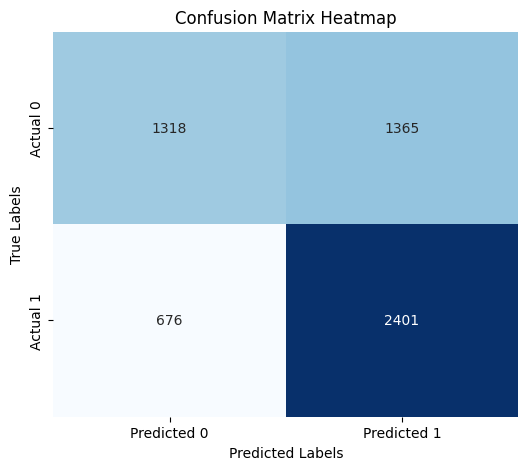

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Set the model to evaluation mode
model.eval()
# Make predictions on the test data128
with torch.no_grad():  # No need to compute gradients for prediction
    y_pred_prob = model(X_test_tensor)  # Output will be between 0 and 1 (probability)

# Convert probabilities to binary predictions (threshold of 0.5)
y_pred = (y_pred_prob > 0.5).float()
# 1. Calculate Accuracy

 
y_pred = y_pred.cpu().numpy()

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n ')

# 3. Plot Confusion Matrix as a Heatmap
def plot_confusion_matrix(cm):
    # Plot using seaborn heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Call the function to plot the confusion matrix
plot_confusion_matrix(cm)

In [36]:
y_pred_prob

tensor([[0.7154],
        [0.6354],
        [0.6354],
        ...,
        [0.0385],
        [0.5460],
        [0.5037]], device='cuda:0')

In [37]:
# Convert X_test to a PyTorch tensor
df_test_tensor = torch.tensor(df_test_transformed.to_numpy(), dtype=torch.float32)

In [38]:
# Ensure the test tensor is on the same device
df_test_tensor = df_test_tensor.to(device)

# Make predictions on the test data
with torch.no_grad():  # No need to compute gradients for prediction
    y_pred_test = model(df_test_tensor)  # Output will be between 0 and 1 (probability)

# If further processing requires CPU, move predictions back to CPU
y_pred_test = y_pred_test.cpu().numpy()

In [39]:
y_pred_test

array([[0.08184302],
       [0.77021253],
       [0.08117159]], dtype=float32)

In [40]:
output = pd.DataFrame(y_pred_test, index=df_test.index, columns=['prediction']).reset_index()


In [41]:
output.head()

,ID,prediction
0,28800,0.081843
1,28801,0.770213
2,28802,0.081172


In [42]:
submission = output.to_csv('/kaggle/working/submission.csv', index=False)